[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/ds-reboot/python-first-part/blob/main/hometasks/Task3_dmrf_OOP.ipynb)

# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.



## Список объектов

In [1]:
import requests
class DownloadObjects():
    dct = {}
    lst = {}
    def dwnObjects(self, pos, size, parts):
        #Скачивание кусками в словарь
        dct = {}
        part_ = 1
        parts = int((size + 1 - pos)/parts)
        for offset_ in range(pos, size, parts):
            limit_ = offset_ + (parts - 1)
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
            print(f'{offset_}:{limit_}')
            res = requests.get(url)
            data = res.json()
            dct.update({part_: data})
            part_ += 1
        return dct
    
    def idToList(self, dct):
        #Все id в один лист кидаем
        lst_ = list()
        for i in dct.keys():
            objects_list = dct[i].get('data').get('list')
            lst_ += objects_list
        objids = [x.get('objId') for x in lst_]
        return objids

In [2]:
down_obj = DownloadObjects()

In [5]:
#Гружу кусками, т.к. сервер выбивает 504 если большими группами грузить.
down_obj.dct.update(down_obj.dwnObjects(1, 12000, 8))

1:1500
1501:3000
3001:4500
4501:6000
6001:7500
7501:9000
9001:10500
10501:12000


In [6]:
#записываю в переменную(лист) класса только id объектов
down_obj.lst = down_obj.idToList(down_obj.dct)


In [14]:
#Удаляю дубликаты (с сервера при дроблении запроса почему-то некоторые записи дублируются)
down_obj.lst = list(set(down_obj.lst))

# Данные по определенному объекту

In [31]:
import pandas as pd
from sqlalchemy import create_engine
class ParseObjects():
    pd_ = pd.DataFrame()
    def upload_to_df(self, id_list):
        pd_ = pd.DataFrame()
        for i in id_list:            
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{i}'
            res = requests.get(url)
            js_res = res.json()
            temp_pd = pd.json_normalize(js_res)
            pd_ = pd.concat([pd_,temp_pd])
        return pd_
    #db,pickle,excel        
    def upload_to_(self, filename, type_, df):
        if type_ == 'excel':
            filename = str(filename) + 'xlsx'
            df.to_excel(filename, index=False)
        elif type_ == 'pickle':
            filename = str(filename) + 'pkl'
            df.to_pickle(filename)
        elif type_ == 'db':
            engine = create_engine('sqlite://', echo=False)
            df = df.applymap(str)
            df.to_sql(filename, con=engine, if_exists='replace', index=False)

In [32]:
parsObj = ParseObjects()
parsObj.pd_ = parsObj.upload_to_df(down_obj.lst)

In [33]:
parsObj.pd_

,errcode,data.id,data.pdId,data.developer.devId,data.developer.devShortCleanNm,data.developer.devShortNm,data.developer.devFullCleanNm,data.developer.problObjCnt,data.developer.buildObjCnt,data.developer.comissObjCnt,...,data.developer.bankruptStage.bankruptStageDesc,data.developer.bankruptStage.bankruptLawUrl,data.developer.orgBankruptMsgDttm,data.metro.id,data.metro.name,data.metro.line,data.metro.color,data.metro.time,data.metro.isWalk,data.metro.colors
0,0,45592,543495,1923,СЗ ШЭЛДОМ,СЗ ШЭЛДОМ,СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИК ШЭЛДОМ,0,9,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,32787,181636,6946,СЗТКС,СЗТКС,СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИКТАТКАМСТРОЙ,0,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,32793,162963,6434,СЗ ДЖЕВОССЕТ,СЗ ДЖЕВОССЕТ,СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИК ДЖЕВОССЕТ,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,32849,167016,1577,СЗ КАПИТАЛ ГРУПП,СЗ КАПИТАЛ ГРУПП,СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИК КАПИТАЛ ГРУПП,0,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,32873,141586,530,СЗ ПРОГРАНД,СЗ ПРОГРАНД,СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИК ПРОГРАНД,0,7,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,32629,173074,7110,ИНВЕСТ-ДВ,ИНВЕСТ-ДВ,ИНВЕСТ-ДВ,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,32677,174688,7689,СК ОСТ,СК ОСТ,СТРОИТЕЛЬНАЯ КОМПАНИЯ ОГНИСТРОЙТВЕРЬ,0,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,32709,178109,2240,МКПК,МКПК,МОСКОВСКИЙ КАРТОНАЖНО-ПОЛИГРАФИЧЕСКИЙ КОМБИНАТ,0,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,32710,90412,7019,СЗ ВСН ИНВЕСТ,СЗ ВСН ИНВЕСТ,СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИК ВСН ИНВЕСТ,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
class CheckDF(ParseObjects):
    def check_(self, df):
        df = df.applymap(str)
        df = df.fillna('')
        df = df.reset_index(drop=True)
        return df


In [53]:
ck = CheckDF()
df = ck.check_(parsObj.pd_)

In [69]:
import datetime
import matplotlib.pyplot as plt

class VisualMethods():
    avg_price, square_liv, parking, flats, floors = list(), list(), list(), list(), list()

    def avg_price_for_m(self, df):
        #ищем среднюю цену за кв. метр по регионам
        regions = df['data.developer.regRegionDesc'].unique()
        avg_price = dict()

        for city in regions:
            if str(city) == 'nan':
                continue
            df_1 = df.loc[(df['data.developer.regRegionDesc'] == city) & ~(df['data.objPriceAvg'].str.contains('nan'))]
            df_1 = df_1.drop_duplicates()
            df_1 = df_1.astype({'data.objPriceAvg':'float'})
            temp = {city: df_1['data.objPriceAvg'].mean()}
            avg_price.update(temp)
        avg_price = sorted(avg_price.items(), key=lambda x: x[1], reverse=True)
        return avg_price
    
    def square_liv(self, df):
        #Объем вводимого жилья по регионам и годам

        regions = df['data.developer.regRegionDesc'].unique()
        square_living = dict()

        for city in regions:
            if str(city) == 'nan':
                continue
            df_2 = df.loc[(df['data.developer.regRegionDesc'] == city)]
            df_2 = df_2.drop_duplicates()
            df_2['data.objReady100PercDt'] = df_2['data.objReady100PercDt'].apply(pd.to_datetime)
            #цикл по годам внутри города
            years = df_2['data.objReady100PercDt'].dt.year.unique()
            for year in years:
                df_temp = df_2.loc[df_2['data.objReady100PercDt'].dt.year == year]
                city_year = str(city) + ' ' + str(year)
                df_temp = df_temp.astype({'data.objSquareLiving':'float'})
                temp = {city_year: df_temp['data.objSquareLiving'].sum()}
                square_living.update(temp)

        square_living = sorted(square_living.items(), key=lambda x: x[1], reverse=True)
        return square_living
    
    def park_flats_floors(self, df):
        #Теперь сравним Этажность домов, количество квартир, количество парковочных мест по регионам
        # - data.objFlatCnt - количество квартир, data.floorMax = количество этажей, data.objElemParkingCnt - количество 
        # парковочных мест

        regions = df['data.developer.regRegionDesc'].unique()
        parking = dict()
        flats = dict()
        floors = dict()


        for city in regions:
            if str(city) == 'nan':
                continue
            df_1 = df.loc[(df['data.developer.regRegionDesc'] == city)]
            df_1 = df_1.drop_duplicates()
            df_1 = df_1.astype({'data.objFlatCnt':'float', 'data.floorMax':'int', 'data.objElemParkingCnt': 'int'})
            temp_flat = {city: df_1['data.objFlatCnt'].sum()}
            temp_floor = {city: df_1['data.floorMax'].max()} #макс этаж ищем по региону
            temp_parking = {city: df_1['data.floorMax'].sum()}

            parking.update(temp_parking)
            flats.update(temp_flat)
            floors.update(temp_floor)


        parking = sorted(parking.items(), key=lambda x: x[1], reverse=True)
        flats = sorted(flats.items(), key=lambda x: x[1], reverse=True)
        floors = sorted(floors.items(), key=lambda x: x[1], reverse=True)
        return parking, flats, floors
    
    def histogram(self, list_, legend):
        #топ 20 для наглядности
        list_ = dict(list_[:20])
        bars = plt.barh(list(list_.keys()), list(list_.values()))
        plt.bar_label(bars, fmt=legend)
        plt.show()

In [71]:
vs = VisualMethods()
vs.avg_price = vs.avg_price_for_m(df)
vs.square_liv = vs.square_liv(df)
vs.parking, vs.flats, vs.floors = vs.park_flats_floors(df)

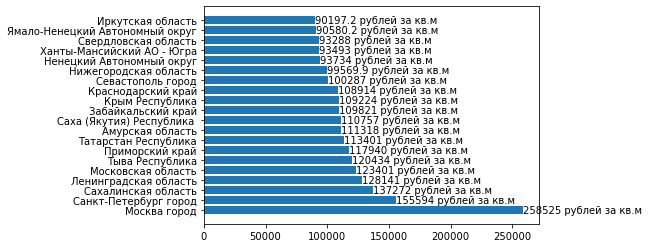

In [73]:
vs.histogram(vs.avg_price, '%g рублей за кв.м')

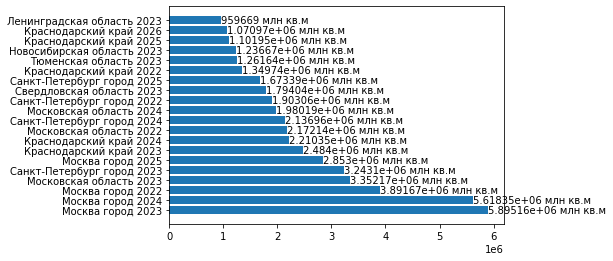

In [74]:
vs.histogram(vs.square_liv, '%g млн кв.м')

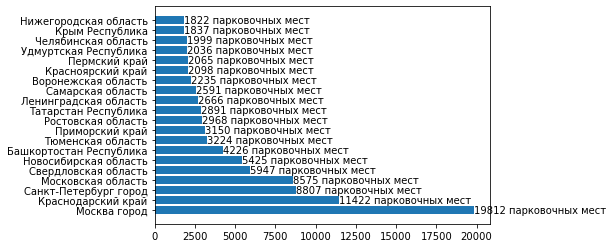

In [75]:
vs.histogram(vs.parking, '%g парковочных мест')

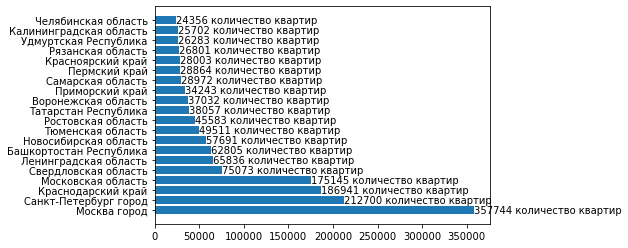

In [76]:
vs.histogram(vs.flats, '%g количество квартир')

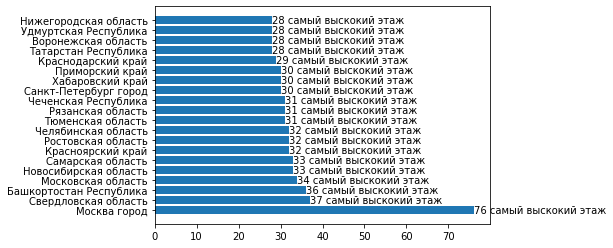

In [77]:
vs.histogram(vs.floors, '%g самый выскокий этаж')